In [18]:
from src.pipelines import get_pipeline
from src.loaders.data_loader import get_train_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
X, y = get_train_data(sample_size=0.01)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
pipeline = get_pipeline()
pipeline = pipeline.fit(X_train, y_train)

Model performance
[[0.36834436 0.63165564]
 [0.29457014 0.70542986]]


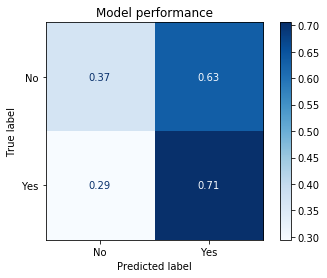

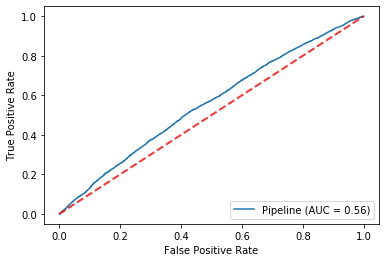

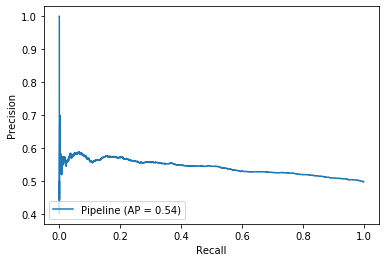

In [21]:
class_names = ["No","Yes"]
disp = plot_confusion_matrix(pipeline, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize='true')

disp.ax_.set_title("Model performance")

print("Model performance")
print(disp.confusion_matrix)
plot_roc_curve(pipeline, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
plt.show()
plot_precision_recall_curve(pipeline, X_test, y_test)